In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import json 
import random 
from warnings import filterwarnings
filterwarnings('ignore')
import math
from datetime import datetime
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPool2D, Dropout 



In [41]:
config = json.loads(open('config.json').read()) 
cifar_model_path_base = config["local"]["cifar_model_path_base"]
train_base = True
save_model_base = True

from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# One-hot encode the labels
y_train = tf.keras.utils.to_categorical(y_train, 10)  # 10 is the number of classes
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Split the training data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)


In [42]:


# Data Augmentation and Rescaling for Training and Validation Sets
train_datagen = ImageDataGenerator(
    rescale=1./255,
shear_range=0.2,    
zoom_range=0.2,
horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)  # Just rescaling for validation data
test_datagen = ImageDataGenerator(rescale=1./255)


# Create Training Set Generator
train_set = train_datagen.flow(
    x_train, y_train,        # Path to the folder containing training images     # Resize images to 150x150
    batch_size=32,                   # Process 32 images per batch
) 

val_set = val_datagen.flow(
    x_val, y_val, 
    batch_size=32
)

test_set = test_datagen.flow(
    x_test, y_test, 
    batch_size=32
)

In [43]:
# Changed to softmax for 10 classes

# Define the CNN Model
classifier = Sequential([
    Conv2D(32, (3, 3), input_shape=(32, 32, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')  
])

In [44]:
if train_base: 
    # Compile the Model
    classifier.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    early_stopping = True
    if early_stopping:
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    else:
        early_stopping = None


    # Train the Model
    history = classifier.fit(
        train_set,
        epochs=200,
        validation_data=val_set,
        callbacks=[early_stopping]
    )
    if save_model_base:
        classifier.save(cifar_model_path_base) 
        # Save history 
        with open(cifar_model_path_base.replace(".keras", "keras").replace(".h5", "h5")+ ".history", 'w') as f:
            f.write(json.dumps(history.history)) 
        
else:
    classifier = tf.keras.models.load_model(cifar_model_path_base)
    with open(cifar_model_path_base.replace(".keras", "keras").replace(".h5", "h5")+ ".history", 'r') as f:
        history = json.loads(f.read()) 




Epoch 1/200
 197/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.1708 - loss: 2.1935

KeyboardInterrupt: 

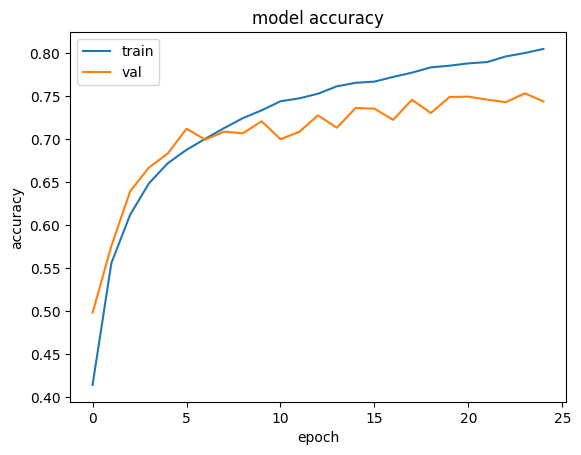

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


### Prediction of Single Image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Predicted Label: 7
True Label: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


Text(0, 0, 'Predicted Label: 7')

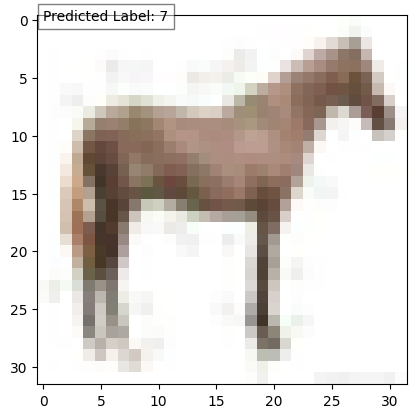

In [ ]:
#get random image from train_set_folder
all_files = []
random_int= random.randint(0, x_train.shape[0]) 
to_plot= x_train[random_int]
label= y_train[random_int]
to_plot = np.expand_dims(to_plot, axis=0)
# Make prediction
prediction = classifier.predict(to_plot)  # No need for batch_size or steps arguments
predicted_label = np.argmax(prediction)
print(f"Predicted Label: {predicted_label}")
print(f"True Label: {label}")
plt.imshow(to_plot[0])
plt.text(0, 0, f"Predicted Label: {predicted_label}", bbox=dict(facecolor='white', alpha=0.5))



In [ ]:
predictions = classifier.predict(x_val/255)
df = pd.DataFrame({
    'predict': predictions.argmax(axis=1),
    'y': y_val.argmax(axis=1) 
}) 


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [ ]:
misclassified = df[df['y']!=df['predict']]
print('Total images in validation set:', df.shape[0]) 
print('Total misclassified image from validation set:', misclassified.shape[0]) 
print('Accuracy:', 1 - misclassified.shape[0]/df.shape[0])

Total images in validation set: 10000
Total misclassified image from validation set: 2511
Accuracy: 0.7489


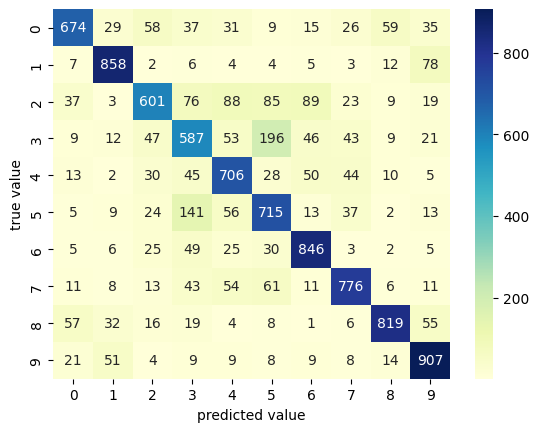

In [ ]:
conf_matrix = confusion_matrix(df.y,df.predict)
sns.heatmap(conf_matrix,cmap="YlGnBu",annot=True,fmt='g');
plt.xlabel('predicted value')
plt.ylabel('true value');

## New model for Cifar-10, based on VGG10 architecture


Redefine Model using: 
1) Additional layers to add robustness to the model
2) Normalisation for model stability
3) Additional dropout to prevent overfitting

In [ ]:
def build_VGG10_model (myInitializer="glorot_uniform", myLoss="categorical_crossentropy", myOptimizer="adam", myMetrics=["accuracy"], myActivation='relu', myDropout_Conv=0.3, myDropout_Dense=0.3):

    model = Sequential()

    model.add(Conv2D(filters=32,kernel_size=(3,3), padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Activation(myActivation))
    model.add(Conv2D(filters=32, padding='same', kernel_size=(3,3)))
    model.add(BatchNormalization())
    model.add(Activation(myActivation))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(myDropout_Conv))

    model.add(Conv2D(filters=64,kernel_size=(3,3), padding='same' ))
    model.add(BatchNormalization())
    model.add(Activation(myActivation))
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same' ))
    model.add(BatchNormalization())
    model.add(Activation(myActivation))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(myDropout_Conv))

    model.add(Conv2D(filters=128,kernel_size=(3,3), padding='same' ))
    model.add(BatchNormalization())
    model.add(Activation(myActivation))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same' ))
    model.add(BatchNormalization())
    model.add(Activation(myActivation))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(myDropout_Conv))

    model.add(Flatten())

    model.add(Dense(2048, use_bias=False, kernel_initializer=myInitializer))
    model.add(BatchNormalization())
    model.add(Activation(myActivation))
    model.add(Dropout(myDropout_Dense))

    model.add(Dense(1024, use_bias=False, kernel_initializer=myInitializer))
    model.add(BatchNormalization())
    model.add(Activation(myActivation))
    model.add(Dropout(myDropout_Dense))

    model.add(Dense(512, use_bias=False, kernel_initializer=myInitializer))
    model.add(BatchNormalization())
    model.add(Activation(myActivation))
    model.add(Dropout(myDropout_Dense))

    model.add(Dense(128, use_bias=False, kernel_initializer=myInitializer))
    model.add(BatchNormalization())
    model.add(Activation(myActivation))
    model.add(Dropout(myDropout_Dense))

    model.add(Dense(10, activation='softmax'))

    model.compile(loss=myLoss, optimizer=myOptimizer, metrics=myMetrics) 

    return model

# No dropout 

In [45]:
save_model_no_dropout = True 
train_model_no_dropout = True 
no_dropout_model = build_VGG10_model(myDropout_Conv=0, myDropout_Dense=0)   

no_dropout_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

no_dropout_history = no_dropout_model.fit(
    train_set,
    epochs=200,
    validation_data=val_set,
    callbacks=[early_stopping]
)
if train_model_no_dropout:
    if save_model_no_dropout:
        no_dropout_model.save("models/no_dropout_model.keras")

        print("Model saved at modes/no_dropout_model.keras")
        history3 = no_dropout_model.fit( 
            train_set,
            epochs=200,
            validation_data=val_set,
            callbacks=[early_stopping]
        ) 
    else:

        print("Model not saved")
else: 
    no_dropout_model = tf.keras.models.load_model("models/no_dropout_model.keras") 

plt.plot(no_dropout_history.history['accuracy'], label='Training Accuracy') # This is with dropout 
plt.plot(no_dropout_history.history['val_accuracy'], label='Validation Accuracy') # This is with dropout 
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy without Dropout')

NameError: name 'build_VGG10_model' is not defined

## With dropout

In [47]:
train_second_model_with_dropout = True 
save_model_with_dropout = True 
cifar_model_path_second_model_dropout = "models/second_model_dropout.keras" 
model2 = build_VGG10_model()
model2.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
if train_second_model_with_dropout:
    history2 = model2.fit(
        train_set,
        epochs=200,
        validation_data=val_set,
        callbacks=[early_stopping]
    )

    if save_model_with_dropout:
        model2.save(cifar_model_path_second_model_dropout)
        print(f"Model saved at {cifar_model_path_second_model_dropout}")
    else:
        print("Model not saved")
else:
    model2 = tf.keras.models.load_model(cifar_model_path_second_model_dropout)
    print(f"Model loaded from {cifar_model_path_second_model_dropout}")


# Plot accuracy and validation accuracy for the recorded epochs
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy with Dropout of 0.3') 
    

NameError: name 'model2' is not defined

NameError: name 'model2' is not defined

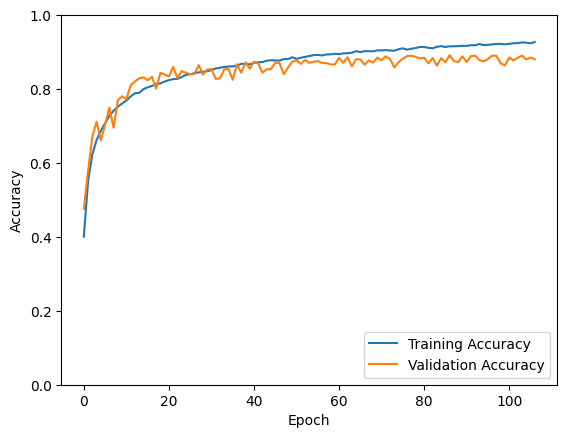

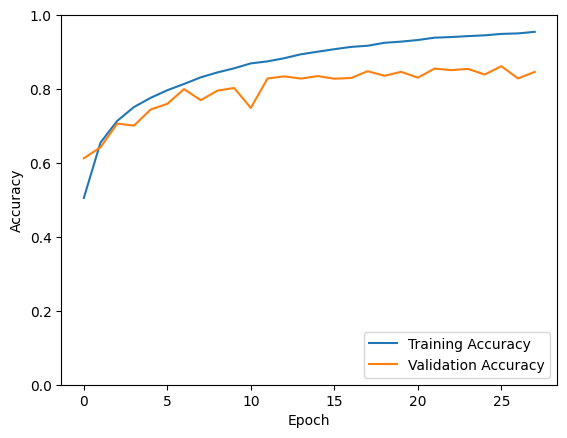